In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Functions as AC
from scipy.stats import loguniform, uniform
from IPython.display import display, Math
import corner
import random 


## Description of System1 and System2 csv files

### Three parameters: 

$\quad$ -time_d: Time (days)

$\quad$ -rv_ms: Radial velocity (m/s)

$\quad$ -sig_rv_ms: Uncertainty on radial velocity measurements (m/s)

In [2]:
df1 = AC.data_loader('system1.csv')
df2 = AC.data_loader('system2.csv')

In [3]:
time1 = np.array(df1['time_d'])
rv1 = np.array(df1['rv_ms'])
sig1 = np.array(df1['sig_rv_ms'])

time2 = np.array(df2['time_d'])
rv2 =  np.array(df2['rv_ms'])
sig2 =  np.array(df2['sig_rv_ms'])

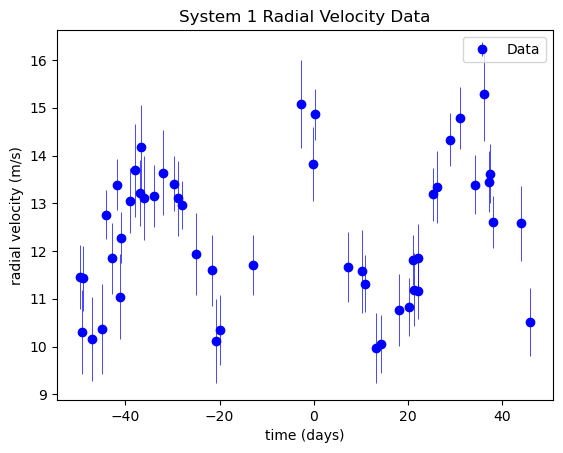

In [4]:
fig = plt.figure()
plt.errorbar(time1, rv1, yerr=sig1, elinewidth=.5, color='blue', marker='o', ls='none', label='Data')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (m/s)')
plt.title('System 1 Radial Velocity Data')
plt.legend()
plt.show()

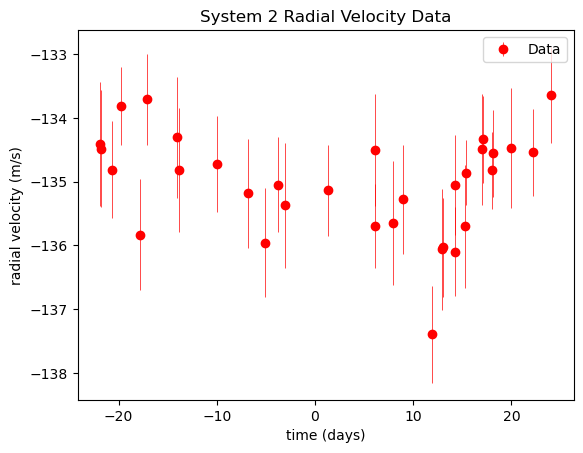

In [5]:
fig = plt.figure()
plt.errorbar(time2, rv2, yerr=sig2, elinewidth=.5, color='red', marker='o', ls='none', label='Data')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (m/s)')
plt.title('System 2 Radial Velocity Data')
plt.legend()
plt.show()

# The Forward Model

### Deriving the loglikelihood

Given a planet of mass m orbiting a star of mass M, with semi-major axis a, and eccentricity 0, the equation for the measured radial velocity of the system is:

$V(t) = V_0+K\cos(nt+\lambda_0)\;\;\;\;(1)\;\;$ where $\;\;K=\frac{m}{m+M}\frac{2\pi a\sin i}{P}\;\;$ is the radial velocity semi amplitude

The parameters of concern in this situation are $\theta=(P, K, \lambda_0, V_0)$

We can find an expression for the loglikelihood function:

Since we know that these measurements are affected by $\textbf{Uncorrelated Gaussian White Noise}$ we can compute the probability of the observation $v_k$ give $\theta$ as:

$p(v_k|\theta)=\frac{1}{\sigma_k\sqrt{2\pi}}exp[-\frac{(v_k-V(t_k;\theta))^2}{2\sigma_k^2}]\;\;\;\;(2)\;\;$

Since the GWN is uncorrelated this means that for each $v_k\;(1,...,k)$ given $\theta$ are independent so to get the total likelihood we simply multiply all probabilities together giving:

$\mathcal{L}=\prod_{k=1}^{N}[\frac{1}{\sigma_k\sqrt{2\pi}}exp[-\frac{(v_k-V(t_k))^2}{2\sigma_k^2}]]\;\;\;\;(3)\;\;$

$\because$ products are annoying to work with we can use properties of logs to get the loglikelihood as a summation as opposed to a product. Taking the natural log of both sides:

$ln\mathcal{L}=-\frac{1}{2}\sum_{k=1}^{N}[\frac{(v_k-V(t_k))^2}{\sigma_k^2}+ln(2\pi\sigma_k^2)]\;\;\;\;(4)\;\;$ Note $\;\;ln(2\pi\sigma_k^2)\;\;$ Doesn't depend on $\theta$


### Linearize V(t)

To start were given equation 1 for our formula for the radial velocity. We're then told that we can express that equation as:

$V(t)=A\cos(nt)+B\sin(nt)+C\;\;\;\;(5)\;\;$ where A, B, and C are constants

This linearization is advantageous to the original formula as it is linear as a function of t, meaning that it'll be easier to work with when calculating the maximum likelihood estimators, whereas the nonlinear formualtion would be difficult in calculating MLE.

### Deriving A, B, and C

Lets now derive A, B, and C's dependence on the oribital/physical parameters

First note the trig identity: $\cos(\alpha+\beta)=\cos(\alpha)\cos(\beta)-\sin(\alpha)\sin(\beta)\;\;\;\;(6)\;\;$

Noticing that we can assign $\alpha=nt$ and $\beta=\lambda_0$ we get the following formulation of $V(t)$:

$V(t)=V_0+K(\cos(nt)\cos(\lambda_0)-\sin(nt)\sin(\lambda_0))\;\;\;\;(7)\;\;$

Organizing terms together as $\;\;V(t)=K\cos(\lambda_0)\cos(nt)-K\sin(\lambda_0)\sin(nt)+V_0\;\;\;\;(8)\;\;$ 

Notice how equation 8 matches the form of equation 5 with (A,B,C) relating to $(K,\lambda_0,V_0)$ by:

$\quad$ $\cdot\;A=K\cos(\lambda_0)$

$\quad$ $\cdot\;B=-K\sin(\lambda_0)$

$\quad$ $\cdot\;C=V_0$

# Calculating the Maximum Likelihood Estimator (MLE)

The MLE is defined as $\hat{\theta}=argmax_\theta\;\mathcal{L}_k(\theta;t)\;\;\;$ or in other words the values of theta that maximize the likelihood

We can express this minimizing $\;[ln(\sigma_k^2)+\frac{(v_k-V(t_k))^2}{\sigma_k^2}]=\sum_{k=1}^{N}\frac{(v_k-Ac_k-Bs_k-C)^2}{\sigma_k^2}\;\;\;$ where $\;\vec{c_k}\equiv\cos(nt_k)\;$ and $\;\vec{s_k}\equiv\sin(nt_k)$

And since the uncertainties are assumed from a normal distrubtuon we can use weighted least squares to maximize $\mathcal{L}$ and find $\hat{\theta}=(\hat{A}\;\hat{B}\;\hat{C})^T$

$\vec{v_k}=\vec{X}\theta+\epsilon\;\;\;$ where $\;\;\vec{v_k}=(v_1.....v_N)^T\;\;$ and $\;\;X=(\vec{c_k}\;\vec{s_k}\;\vec{1})$

$\vec{X}^T\vec{W}\vec{X}\hat{\theta}=\vec{X}^T\vec{W}\vec{v_k}\Rightarrow\hat{\theta}=(\vec{X}^T\vec{W}\vec{X})^{-1}\vec{X}^T\vec{W}\vec{v_k}$

Where $\vec{W}$ is a matrix with $\frac{1}{\sigma_k^2}$ on the diagonals


In [6]:
# time, rv, and uncertainty for k times
tk=time1 # (days)
vk=rv1 # (m/s)
sigk=np.array(sig1)

# Period and mean-motion
P = 33 # (days)
n=2*np.pi / P

# Columns of X
ck = np.cos(n*tk) 
sk = np.sin(n*tk)
ones = np.ones(len(tk))

# Make X and transpose of X
X = np.vstack((ck, sk, ones)).T
X_T= X.T

# Weighted diagonal matrix
W = np.diag(1 / sigk**2)

In [7]:
# Calculate maximum likelihood estimator for system 1 data
mle=np.linalg.inv(X_T@W@X)@X_T@W@rv1
print(mle)

# MLE parameters
A=mle[0]
B=mle[1]
C=mle[2]

[ 1.73312835 -0.39934569 12.35107417]


Now lets convert from A, B, and C to our orbital/physical parameters $(K, \lambda_0, V_0)$

Remember:

$\cdot\;A=K\cos(\lambda_0)$

$\cdot\;B=-K\sin(\lambda_0)$

$\cdot\;C=V_0$

To get K in terms of A and B, we take the square of A and B and add them together getting $A^2+B^2=K^2(\cos^2(\lambda_0)+\sin^2(\lambda_0))=K^2$

$\therefore\; K=\sqrt{A^2+B^2}$

Now to get $\lambda_0$ in terms of A and B, we can divide B by A giving $\frac{B}{A}=-\frac{K\sin(\lambda_0)}{K\cos(\lambda_0)}=-\tan(\lambda_0)$

$\therefore\; \lambda_0=\arctan(\frac{-B}{A})$

And of course $V_0=C$, so our job is done there

In [28]:
K = np.sqrt(A**2+B**2)
lamb0=np.arctan2(-B,A) #arctan2 handles quadrant relavant information
V0=C

display(Math(r'\text{The maximum likelihood estimate of } K, \lambda_0, \text{ and } V_0 \text{ are } K=' + str(K) +r'\text{, }'+ r'\lambda_0=' + str(lamb0)+r'\text{, }' +r'V_0=' + str(V0)))





<IPython.core.display.Math object>

# Metropolis-Hastings

### Bayes Theorem Review:

#### $p(\theta|y)=\frac{p(y|\theta)p(\theta)}{p(y)}\;\; ; \;\; p(y)=\int_{\theta\in\Theta}p(y|\theta)p(\theta)d\theta$

#### $\alpha=min(1,\frac{f(\theta^{'})q_{\theta^{'}}(\theta_i)}{f(\theta_i)q_{\theta_i}(\theta^{'})})$

Since we choose the proposal distribution to be symmetric, $\alpha$ simplifies to

#### $\alpha=min(1,\frac{f(\theta^{'})}{f(\theta_i)})$

Which we can then express as:

#### $\alpha=min(1,\frac{p(y|\theta^{'})p(\theta^{'})}{p(y|\theta)p(\theta)})$

The advantage of MH for generating samples from the posterior over generating from an inverse CDF is due to not having to deal with the p(y) term, or the evidence, which is often difficult to compute.


The advantage of the MH algorithm for generating samples from the posterior over generating samples using the inverse CDF method is:

1. **No need to compute the normalizing constant**: MH does not require computing p(y) (the evidence). The evidence is often analytically hard to work with and computationally expensive to calculate.

2. **Only requires ratios**: MH only needs to evaluate the difference between the log posterior densities. This means we only need to evaluate the log likelihood and log prior, which are typically straightforward to compute as I show below.

3. **CDF is impractical in multiple dimensions**: The inverse CDF method is difficult to use in a multidimensional parameter space (like the one we are in), whereas MH handles multiple parameters just fine.



We can further compute the logarithm of $\alpha$ to be:

#### $ln\alpha=ln(p(y|\theta^{'})p(\theta^{'})) - ln(p(y|\theta)p(\theta))$

Which is simply just the difference between of the log posterior of the proposed theta minus the log posterior of the initial theta.


With all this in mind, we then define the log prior and log likelihood functions which will come in handy when we construct the Metropolis Hastings algorithm

In [29]:
def logprior(theta):
    P, K, lamb0, V0 = theta

    logp = 0.0

    # log unif log pdf: log p(x) = -log(x) - log(log(b/a))
    # unif log pdf: log p(x) = -log(b-a)
    
    if 1.0 <= P <= 1000.0:
        logp += -np.log(P) - np.log(np.log(1000.0))
    else:
        return -np.inf

    if 0.01 <= K <= 100.0:
        logp += -np.log(K) - np.log(np.log(100.0/0.01))
    else:
        return -np.inf

    if 0.0 <= lamb0 <= 2*np.pi:
        logp += -np.log(2*np.pi)
    else:
        return -np.inf
    
    if -1e4 <= V0 <= 1e4:
        logp += -np.log(2e4)
    else:
        return -np.inf

    return logp
def model(theta, t):
    P, K, lamb0, V0 = theta
    return V0 + K*np.cos((2*np.pi/P*t + lamb0))

def loglike(theta, t, v, sigma):
    model_v = model(theta, t)         
    residual   = v - model_v      
    return -0.5 * np.sum((residual / sigma)**2 + np.log(2*np.pi*sigma**2))

### To generate our proposal we add a random value onto our theta that is dependent on the gaussian function for the variables of interest

### The proposal function looks like: $g(P-P',\sigma_P)g(K-K', \sigma_K)g(\lambda_0-\lambda_0',\sigma_{\lambda_0})g(V_0-V_0',\sigma_{V_0})$ 

### Where $g(x,\sigma)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{x^2}{2\sigma^2}}$

In [22]:
def generate_proposal(theta, sigmas):

    theta = np.asarray(theta)
    sigmas = np.asarray(sigmas)

    step = np.random.normal(loc=0.0, scale=sigmas, size=theta.shape)
        
    return theta + step

theta_start = [33, K, lamb0, V0]
sigma_start = [0.02, 0.02, 0.01, 1.0]
theta_prop = generate_proposal(theta_start, sigma_start)
print(theta_start)
print(theta_prop)

[33, np.float64(1.7785417752883772), np.float64(0.2264662970248616), np.float64(12.351074172134888)]
[32.98636579  1.81209828  0.22398683 12.79826595]


### Now we can feed our intial parameters and uncertainties into a function that will

1) Create the chain

2) Calculate the initial log prior, log likelihood, and log posterior

3) Generate proposed theta

4) Calculate a proposed log prior, log likelihood, and log posterior

5) Calculate the ratio and compare to the log random number

    $\quad$ a) if ratio > log random, accept the proposed parameters

    $\quad$ b) if ratio < log random, reject the proposed parameters and add the old ones to the chain

6) Repeat for whatever number of steps

In [23]:
def mh_sampler(theta_start, sigma_start, nsamples, t, v, sig):
    theta0 = np.asarray(theta_start, dtype=float)
    sigma0 = np.asarray(sigma_start, dtype=float)  
    length = len(theta0)

    # Where we will store indices of our Markov Chain
    chain = np.zeros((nsamples, length))
    chain[0] = theta0 # Set first link in the chain as the initial theta

    
    lnprior0 = logprior(theta0) # Calculate initial prior from proposed theta
    
    if not np.isfinite(lnprior0): # Handles priors outside range
        raise ValueError("Starting theta has -inf prior; choose a different starting point.")

    
    # Calculate the loglike and posterior for the initial proposal
    lnlike0 = loglike(theta0, t, v, sig)
    lnpost0 = lnprior0 + lnlike0

    # Sets proposal and acceptance counters
    n_accepted = 0
    n_proposed = 1 

    
    while n_proposed < nsamples:
        # Generate parameter proposal and calculate prior
        theta1 = generate_proposal(theta0, sigma0)
        lnprior1 = logprior(theta1)

        
        if not np.isfinite(lnprior1): # Checks if proposed prior is infinite
            chain[n_proposed] = theta0
            n_proposed += 1
            continue
        
        # Calculate likelihood and posterior of proposed theta
        lnlike1 = loglike(theta1, t, v, sig)
        lnpost1 = lnlike1 + lnprior1

        # Hastings Step: New posterior / Old posterior
        ratio = lnpost1 - lnpost0 


        rand_ln = np.log(np.random.uniform(0.0, 1.0))

        # If ratio is greater than the random number, we accept!!
        if ratio > rand_ln:
            n_accepted += 1

            # Swap inputs to newest value
            theta0 = theta1
            lnprior0, lnlike0, lnpost0 = lnprior1, lnlike1, lnpost1

        # Adds either the accepted theta to the chain or adds the proposed theta to the chain
        chain[n_proposed] = theta0
        n_proposed += 1
    
    accept_rate = n_accepted / nsamples
    return chain, accept_rate


In [24]:
sigmas = [0.01, 0.01, 0.005, 0.5]
chain, acc = mh_sampler(theta_start, sigmas, 300000, time1, rv1, sig1)

In [13]:
# The sigma's above were chosen due to achieving an accuracy of ~23% after testing various different sigmas
print('The accuracy from our sampler given the above sigmas is ' + str(acc*100) + r'% accurate')

The accuracy from our sampler given the above sigmas is 23.25% accurate


### With our MCMC Sampler, we can generate the chain and accuracy

### With that information we can make plots of the Markov Chains for each variable to see how each variable evolves on the posterior

[33.         33.         33.         ... 33.71793715 33.71793715
 33.71793715]
0.23092666666666667


Text(0, 0.5, 'Velocity at Barycenter $(V_0)$')

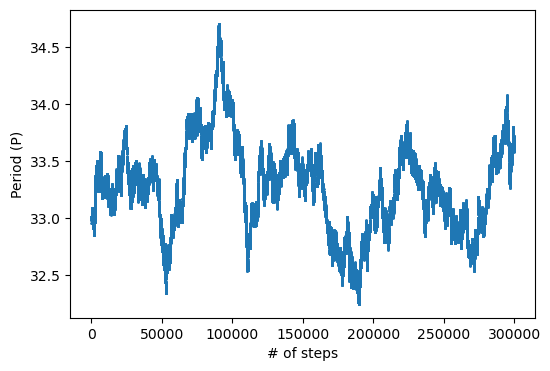

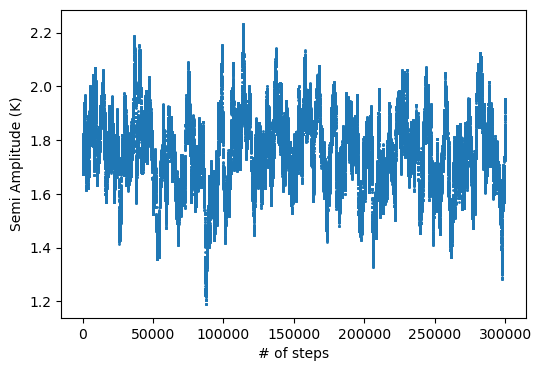

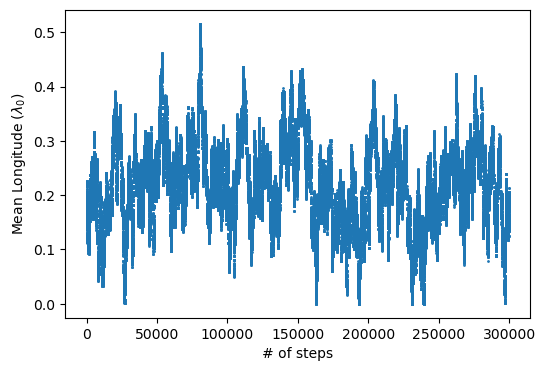

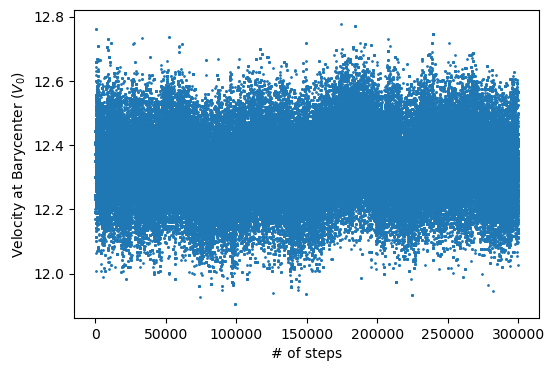

In [30]:
x = np.linspace(0, len(chain), len(chain))
print(chain[:, 0])
print(acc)

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,0], s=1)
plt.xlabel('# of steps')
plt.ylabel(r'Period (P)')

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,1], s=1)
plt.xlabel('# of steps')
plt.ylabel(r'Semi Amplitude (K)')

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,2], s=1)
plt.xlabel('# of steps')
plt.ylabel(r'Mean Longitude $(\lambda_0)$')

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,3], s=1)
plt.xlabel('# of steps')
plt.ylabel(r'Velocity at Barycenter $(V_0)$')

## Convergence Test (Gelman-Rubin) - (Optional)

1) Run M different chains, with different starting points

2) Discard burnins

3) Calculate for each parameter the posterior mean

4) Calculate the intra-chain variance

5) Calculate the mean of all chains

6) Compute how the individual means vary around the joint mean

7) Compute the average variances (W) of the chains

8) Define V; under convergence, this is an unbiased estimator of the true variance. But if the chains have converged, then W is also an unbiased estimate of the true variance

9) Test wether R=sqrt(V/W) $\approx$ 1. If not, then convergence has not been reached

Source: https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/astrophysics/public/icic/data-analysis-workshop/2018/Convergence-Tests.pdf

In [31]:
print(33)
print(K)
print(lamb0)
print(V0)

33
1.7785417752883772
0.2264662970248616
12.351074172134888


In [ ]:
n_chains = 5
n_samples = 50000
burnin_frac = 0.25

sigmas = [0.01, 0.01, 0.005, 0.5]

Chains = []
Acc = []
for ii in range(n_chains):
    # Generate new random starting values for each iteration
    periods = random.uniform(33 * 0.98, 33 * 1.02)    
    amplitudes = random.uniform(K * 0.95, K * 1.05)   
    phases = random.uniform(lamb0 - 0.1, lamb0 + 0.1) 
    velos = random.uniform(V0 - 1, V0 + 1)            
    theta_starts = [periods, amplitudes, phases, velos]
    
    chain, acc = mh_sampler(theta_starts, sigmas, n_samples, time1, rv1, sig1)
    Acc.append(acc)
    Chains.append(chain)


# Finds indice at a quarter of data and takes everything after that
Cut_chains = []
for chain in Chains:
    burnin = int(n_samples * burnin_frac)
    Cut_chains.append(chain[burnin:, :])


Running chain 1/5...
  Acceptance rate: 0.231
Running chain 2/5...
  Acceptance rate: 0.231
Running chain 3/5...
  Acceptance rate: 0.232
Running chain 4/5...
  Acceptance rate: 0.236
Running chain 5/5...
  Acceptance rate: 0.230

Total samples analyzed: 5 chains × 37500 samples


In [33]:
for ii in range(len(Cut_chains)):
    Cut_chains[ii][:, 2] = Cut_chains[ii][:, 2] % (2 * np.pi)

In [34]:
individual_P_means = []
individual_K_means = []
individual_lamb_means = []
individual_V_means = []

intra_chain_vars_P = []
intra_chain_vars_K = []
intra_chain_vars_lamb = []
intra_chain_vars_V = []

M = len(Cut_chains)  # Number of chains
N = len(Cut_chains[0])  # Length of each chain

for ii in range(len(Cut_chains)):
    post_mean = np.mean(Cut_chains[ii], axis=0)
    P_mean, K_mean, lam0_mean, V0_mean = post_mean
    individual_P_means.append(P_mean)
    individual_K_means.append(K_mean)
    individual_lamb_means.append(lam0_mean)
    individual_V_means.append(V0_mean)
    
    intra_chain_vars_P.append(np.var(Cut_chains[ii][:, 0], ddof=1))
    intra_chain_vars_K.append(np.var(Cut_chains[ii][:, 1], ddof=1))
    intra_chain_vars_lamb.append(np.var(Cut_chains[ii][:, 2], ddof=1))
    intra_chain_vars_V.append(np.var(Cut_chains[ii][:, 3], ddof=1))

P_mean = np.mean(individual_P_means)
K_mean = np.mean(individual_K_means)
lamb_mean = np.mean(individual_lamb_means)
V_mean = np.mean(individual_V_means)




B_P = (N / (M - 1)) * np.sum([(theta_m - P_mean)**2 for theta_m in individual_P_means])
B_K = (N / (M - 1)) * np.sum([(theta_m - K_mean)**2 for theta_m in individual_K_means])
B_lamb = (N / (M - 1)) * np.sum([(theta_m - lamb_mean)**2 for theta_m in individual_lamb_means])
B_V = (N / (M - 1)) * np.sum([(theta_m - V_mean)**2 for theta_m in individual_V_means])

W_P = np.mean(intra_chain_vars_P)
W_K = np.mean(intra_chain_vars_K)
W_lamb = np.mean(intra_chain_vars_lamb)
W_V = np.mean(intra_chain_vars_V)

V_hat_P = ((N - 1) / N) * W_P + ((M + 1) / (M * N)) * B_P
V_hat_K = ((N - 1) / N) * W_K + ((M + 1) / (M * N)) * B_K
V_hat_lamb = ((N - 1) / N) * W_lamb + ((M + 1) / (M * N)) * B_lamb
V_hat_V = ((N - 1) / N) * W_V + ((M + 1) / (M * N)) * B_V

# Gelman-Rubin statistic: R̂ = √(V̂/W)
R_hat_P = np.sqrt(V_hat_P / W_P)
R_hat_K = np.sqrt(V_hat_K / W_K)
R_hat_lamb = np.sqrt(V_hat_lamb / W_lamb)
R_hat_V = np.sqrt(V_hat_V / W_V)

print(f"Gelman-Rubin R̂ statistics:")
print(f"P: {R_hat_P:.4f}")
print(f"K: {R_hat_K:.4f}")
print(f"λ: {R_hat_lamb:.4f}")
print(f"V: {R_hat_V:.4f}")

Gelman-Rubin R̂ statistics:
P: 2.1799
K: 1.0419
λ: 1.0723
V: 1.0483


### After running the Gelman-Rubin Convergence test we got values $\hat{R}$ of

$\quad \hat{R}$ for P: 1.3100

$\quad \hat{R}$ for K: 1.0235

$\quad \hat{R}$ for $\lambda_0$: 1.0515

$\quad \hat{R}$ for $V_0$: 1.0163

Since $\hat{R}\approx 1$ we can confidently say that our markov chain converges

### In order to further explore the posterior distributions we can make a corner plot of the samples for each parameter

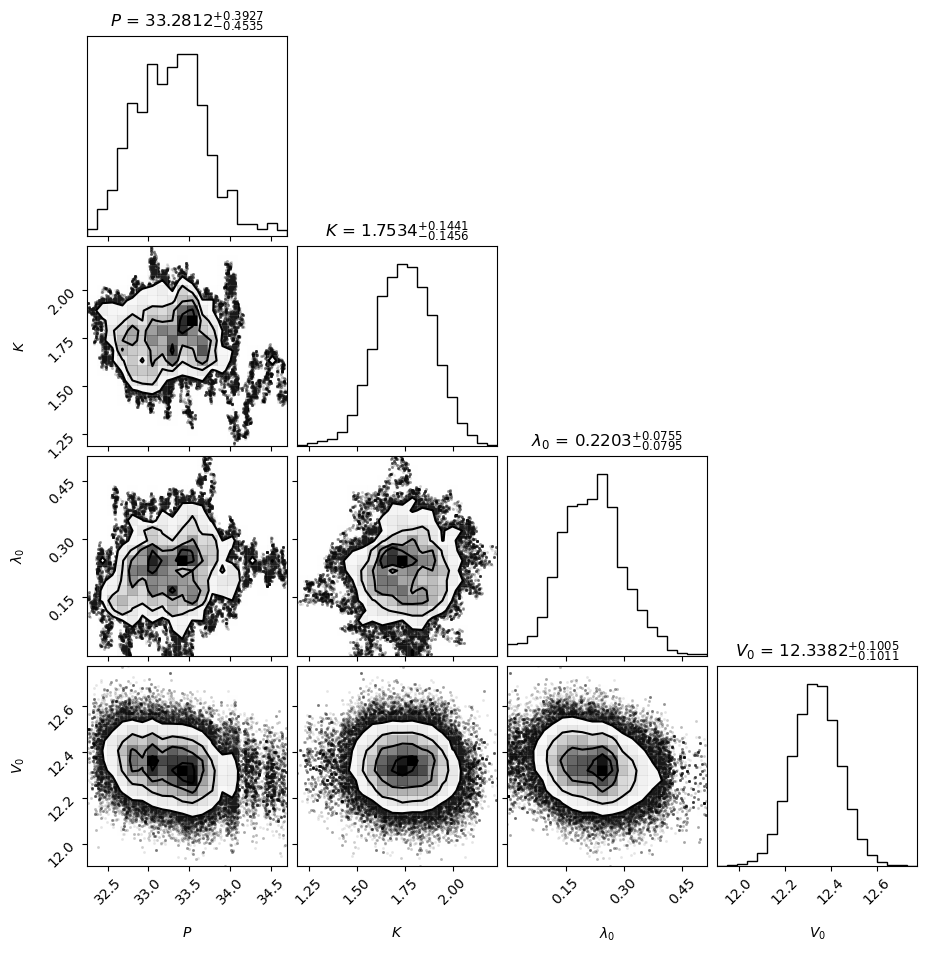

Posterior means:
P = 33.278924
K = 1.751334
λ0 = 0.219566
V0 = 12.337947


Posterior medians:
P = 33.281230
K = 1.753434
λ0 = 0.220275
V0 = 12.338181


In [27]:
nsamples = chain.shape[0]

# Finds indice at a quarter of data and takes everything after that
burnin = nsamples // 4
samples = chain[burnin:, :] 

labels = [r"$P$", r"$K$", r"$\lambda_0$", r"$V_0$"]
fig = corner.corner(samples, labels=labels, show_titles=True, title_fmt=".4f")
plt.show() 

# Calculate posterior means and medians
post_mean   = np.mean(samples, axis=0)
post_median = np.median(samples, axis=0)

P_mean, K_mean, lam0_mean, V0_mean = post_mean
P_med, K_med, lam0_med, V0_med = post_median

# Print posterior means and medians
print("Posterior means:")
print(f"P = {P_mean:.6f}")
print(f"K = {K_mean:.6f}")
print(f"λ0 = {lam0_mean:.6f}")
print(f"V0 = {V0_mean:.6f}")
print('\n')
print("Posterior medians:")
print(f"P = {P_med:.6f}")
print(f"K = {K_med:.6f}")
print(f"λ0 = {lam0_med:.6f}")
print(f"V0 = {V0_med:.6f}")




### To find the minimum mass (msini) we can start by looking at the Semi-Amplitude

### $K=\frac{m}{M+m}\frac{2\pi a \sin i}{P}\cos(\frac{2\pi}{P}+\lambda_0)$

### Using the assumption that M>>m, that equation simplifies to:

### $K=\frac{m}{M}\frac{2\pi a \sin i}{P}\cos(\frac{2\pi}{P}+\lambda_0)$

### We can then reorder this to isolate the minimum mass to be:

### $m\sin i=K\frac{MP}{2\pi a}$ and using Keplers third law: $P^2=\frac{4\pi^2}{GM}a^3$

### $\therefore a=(\frac{P^2GM}{4\pi^2})^\frac{1}{3}$ which we can sub back into our min mass formula yielding

### $m\sin i=K(\frac{P}{2\pi G})^\frac{1}{3}\cdot M^\frac{2}{3}$

### We can now use this formula to calculate the minimum mass given all our samples (minus the burn in)



In [35]:
def min_mass(P, K, M):
    G = 6.67430e-11 
    return K * (P / (2 * np.pi * G))**(1/3) * M**(2/3)

nsamples = chain.shape[0]


# Finds indice at a quarter of data and takes everything after that
burnin = nsamples // 4
samples = chain[burnin:, :] 

minimum_masses = []
for ii in range(len(samples)):
    M = 1.98847e30 # 1 Solar Mass
    P = samples[:, 0][ii] * 86400.0 # converts to seconds
    minimum_masses.append(min_mass(P, samples[:, 1][ii], M))
    
minimum_masses = np.asarray(minimum_masses)
M_earth  = 5.972e+24 
m = minimum_masses / M_earth

minimum mass mean = 9.119453297517424 M_earth
minimum mass median = 9.151746377985466 M_earth


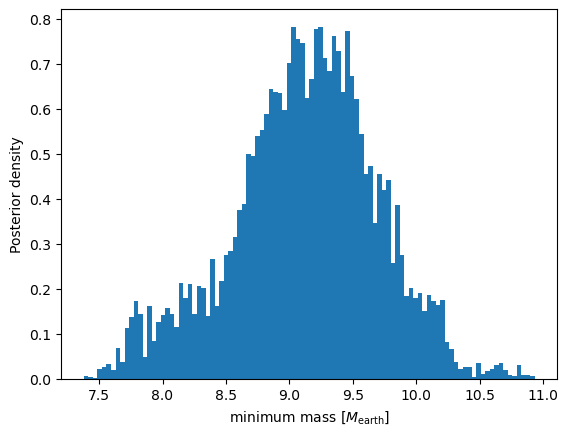

In [36]:
min_mass_mean = np.mean(m)
min_mass_median = np.median(m)

print(f"minimum mass mean = {min_mass_mean} M_earth")
print(f"minimum mass median = {min_mass_median} M_earth")

# --- Histogram of m sin i ---
plt.hist(m, bins=100, density=True)
plt.xlabel(r"minimum mass $[M_{\rm earth}]$")
plt.ylabel("Posterior density")
plt.show()

In [37]:
alpha = 0.95
m = np.array(m)
sorted_m = np.sort(m)
n = len(sorted_m)


k = int(np.floor(alpha * n))


interval_widths = sorted_m[k:] - sorted_m[:n - k]

# index of the smallest-width interval
imin = np.argmin(interval_widths)

m_hpd_low  = sorted_m[imin]
m_hpd_high = sorted_m[imin + k]

print(f"Smallest 95% credible interval (HPD): [{m_hpd_low:.4f}, {m_hpd_high:.4f}]")

Smallest 95% credible interval (HPD): [7.8778, 10.2077]


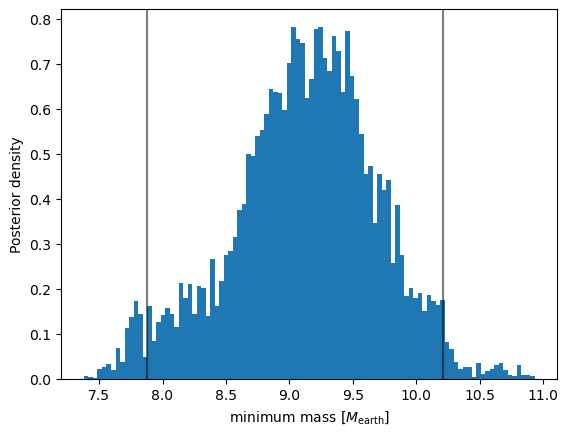

In [38]:
plt.hist(m, bins=100, density=True)
plt.xlabel(r"minimum mass $[M_{\rm earth}]$")
plt.ylabel("Posterior density")
plt.axvline(m_hpd_low, color='black', alpha=.5)
plt.axvline(m_hpd_high, color='black', alpha=.5) 
plt.show()

Central 95% credible interval (equal tails): [7.8234, 10.1847]


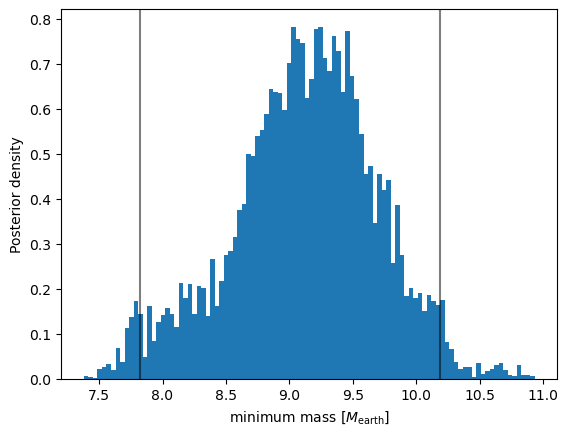

In [39]:
m_low = np.percentile(m, 2.5)
m_high = np.percentile(m, 97.5)
print(f"Central 95% credible interval (equal tails): [{m_low:.4f}, {m_high:.4f}]")

plt.hist(m, bins=100, density=True)
plt.xlabel(r"minimum mass $[M_{\rm earth}]$")
plt.ylabel("Posterior density")
plt.axvline(m_low, color='black', alpha=.5)
plt.axvline(m_high, color='black', alpha=.5) 
plt.show()

In [41]:
# HPD (Smallest) 95% credible interval
alpha = 0.95
m_arr = np.array(m)
sorted_m = np.sort(m_arr)
n = len(sorted_m)

k = int(np.floor(alpha * n))
interval_widths = sorted_m[k:] - sorted_m[:n - k]
imin = np.argmin(interval_widths)

m_hpd_low = sorted_m[imin]
m_hpd_high = sorted_m[imin + k]

# Equal-tails 95% credible interval
m_equal_low = np.percentile(m, 2.5)
m_equal_high = np.percentile(m, 97.5)

# Calculate asymmetric uncertainties
hpd_plus = m_hpd_high - min_mass_median
hpd_minus = min_mass_median - m_hpd_low
et_plus = m_equal_high - min_mass_median
et_minus = min_mass_median - m_equal_low

print("SYSTEM 1 MINIMUM MASS ESTIMATES")
print(f"\nPoint Estimates:")
print(f"  Posterior Mean:   {min_mass_mean:.2f} M_Earth")
print(f"  Posterior Median: {min_mass_median:.2f} M_Earth")

print(f"\n95% Credible Intervals:")
print(f"  HPD (Smallest):   [{m_hpd_low:.2f}, {m_hpd_high:.2f}] M_Earth")
display(Math(r'm_{\rm min, HPD} = ' + f'{min_mass_median:.2f}' + r'^{+' + f'{hpd_plus:.2f}' + r'}_{-' + f'{hpd_minus:.2f}' + r'} \, M_{\oplus}'))

print(f"\n  Equal-Tails:      [{m_equal_low:.2f}, {m_equal_high:.2f}] M_Earth")
display(Math(r'm_{\rm min, ET} = ' + f'{min_mass_median:.2f}' + r'^{+' + f'{et_plus:.2f}' + r'}_{-' + f'{et_minus:.2f}' + r'} \, M_{\oplus}'))

SYSTEM 1 MINIMUM MASS ESTIMATES

Point Estimates:
  Posterior Mean:   9.12 M_Earth
  Posterior Median: 9.15 M_Earth

95% Credible Intervals:
  HPD (Smallest):   [7.88, 10.21] M_Earth


<IPython.core.display.Math object>


  Equal-Tails:      [7.82, 10.18] M_Earth


<IPython.core.display.Math object>

### 1) MCMC is important for finding the minimum mass of planets from RV data because it provides us with a distribution for the mass estimate which allows us to find the mass of the planet with rigorous uncertainties, not just a single point estimate. This proper mass estimate can help astronomers to further characterize planets of interest.

### 2) MCMC also gives us how the parameters of interest are correleted with each other (as seen in the corner plot). If we were to compute uncertainties on the individual parameters, and then tried to calculate the min mass, our uncertainties would be wrong, as we didn't take into account how the parameters are correlated.

### 3) In astrophysics, we often can't explicitly write down the posterior distribution of interest. The MCMC allows us to simply use the likelihood and priors (easy to evaluate) in order to sample from the posterior!
